## Manufacture Order Durable Goods Time Series

In [1]:
!pip install alpha_vantage
!pip install statsmodels
!pip install gluonts
!pip install mxnet

In [2]:
import os 
import numpy as np
import pandas as pd
from datetime import datetime
from alpha_vantage.foreignexchange import ForeignExchange
from pprint import pprint

In [3]:
from gluonts.dataset.common import ListDataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
import mxnet as mx 

In [4]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'Mean Square Error is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'Mean Absolute Error is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'Root Mean Square Error is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'Mean Absolute Percentage Error is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 score is : {metrics.r2_score(y_true, y_pred)}',end='\n\n') 

## Manufacture new orders of durable goods

In [5]:
import requests

In [6]:
api_key = os.getenv('ALPHAVANTAGE_API_KEY')

In [7]:
url = f"https://www.alphavantage.co/query?function=DURABLES&apikey={api_key}"
r = requests.get(url)

In [8]:
data = r.json()
print(data)

{'name': 'Manufacturer New Orders: Durable Goods', 'interval': 'monthly', 'unit': 'millions of dollars', 'data': [{'date': '2022-02-01', 'value': '265296'}, {'date': '2022-01-01', 'value': '260087'}, {'date': '2021-12-01', 'value': '281341'}, {'date': '2021-11-01', 'value': '257601'}, {'date': '2021-10-01', 'value': '259457'}, {'date': '2021-09-01', 'value': '271323'}, {'date': '2021-08-01', 'value': '265120'}, {'date': '2021-07-01', 'value': '240387'}, {'date': '2021-06-01', 'value': '276422'}, {'date': '2021-05-01', 'value': '247305'}, {'date': '2021-04-01', 'value': '246489'}, {'date': '2021-03-01', 'value': '279768'}, {'date': '2021-02-01', 'value': '236976'}, {'date': '2021-01-01', 'value': '222873'}, {'date': '2020-12-01', 'value': '242573'}, {'date': '2020-11-01', 'value': '222229'}, {'date': '2020-10-01', 'value': '233711'}, {'date': '2020-09-01', 'value': '236648'}, {'date': '2020-08-01', 'value': '219612'}, {'date': '2020-07-01', 'value': '205655'}, {'date': '2020-06-01', 'va

In [9]:
df3 = pd.DataFrame(data['data'])
df3.head()

date   value
0  2022-02-01  265296
1  2022-01-01  260087
2  2021-12-01  281341
3  2021-11-01  257601
4  2021-10-01  259457

In [10]:
df3.dtypes

date     object
value    object
dtype: object

In [11]:
df3.date = pd.to_datetime(df3.date)
df3.rename(columns={'value': 'Million_dollars'}, inplace=True)
df3['Million_dollars'] = df3['Million_dollars'].astype(int)
df3.dtypes

date               datetime64[ns]
Million_dollars             int64
dtype: object

In [12]:
df3.tail()

date  Million_dollars
356 1992-06-01           131268
357 1992-05-01           122274
358 1992-04-01           123268
359 1992-03-01           129309
360 1992-02-01           118429

In [13]:
df3 = df3.set_index('date')
df3.head()

Million_dollars
date                       
2022-02-01           265296
2022-01-01           260087
2021-12-01           281341
2021-11-01           257601
2021-10-01           259457

In [14]:
df3.index

DatetimeIndex(['2022-02-01', '2022-01-01', '2021-12-01', '2021-11-01',
               '2021-10-01', '2021-09-01', '2021-08-01', '2021-07-01',
               '2021-06-01', '2021-05-01',
               ...
               '1992-11-01', '1992-10-01', '1992-09-01', '1992-08-01',
               '1992-07-01', '1992-06-01', '1992-05-01', '1992-04-01',
               '1992-03-01', '1992-02-01'],
              dtype='datetime64[ns]', name='date', length=361, freq=None)

Time series should be in ascending order. We need to reverse this one.

In [15]:
df3 = df3[::-1]

In [16]:
df3.head()

Million_dollars
date                       
1992-02-01           118429
1992-03-01           129309
1992-04-01           123268
1992-05-01           122274
1992-06-01           131268

In [17]:
df3.index

DatetimeIndex(['1992-02-01', '1992-03-01', '1992-04-01', '1992-05-01',
               '1992-06-01', '1992-07-01', '1992-08-01', '1992-09-01',
               '1992-10-01', '1992-11-01',
               ...
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
               '2022-01-01', '2022-02-01'],
              dtype='datetime64[ns]', name='date', length=361, freq=None)

In [18]:
from datetime import datetime, timedelta
train_dataset_end = datetime(2020,12,1)
test_dataset_end = datetime(2022,2,1)

In [19]:
train_data = df3[:train_dataset_end]
test_data = df3[train_dataset_end+timedelta(days=30):test_dataset_end]

In [20]:
test_data

Million_dollars
date                       
2021-01-01           222873
2021-02-01           236976
2021-03-01           279768
2021-04-01           246489
2021-05-01           247305
2021-06-01           276422
2021-07-01           240387
2021-08-01           265120
2021-09-01           271323
2021-10-01           259457
2021-11-01           257601
2021-12-01           281341
2022-01-01           260087
2022-02-01           265296

<AxesSubplot:xlabel='date'>

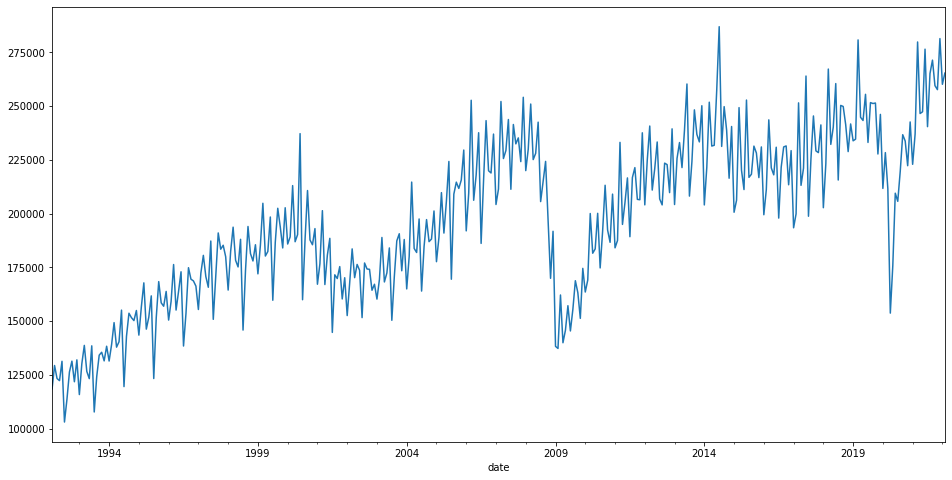

In [21]:
df3.Million_dollars.plot(figsize=(16,8))

In [22]:
df3['Million dollars differencing'] = df3.Million_dollars - df3.Million_dollars.shift(1)  
df3['Million dollars second differencing'] = df3['Million dollars differencing'] - df3['Million dollars differencing'].shift(1) 

In [23]:
from statsmodels.tsa.stattools import adfuller 

In [24]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [25]:
adf_test(df3['Million dollars differencing'].dropna())

ADF Statistics: -5.278932291461502
p- value: 6.053552819961064e-06
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


Differencing level = 1.  Integration d = 1.

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

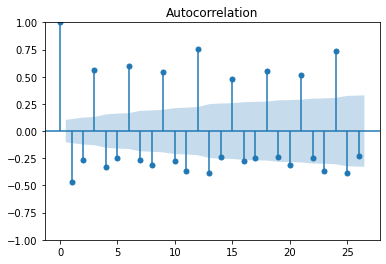

In [27]:
acf = plot_acf(df3['Million dollars differencing'].dropna())

MA q=25

/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


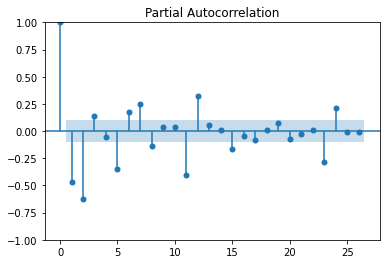

In [28]:
pacf = plot_pacf(df3['Million dollars differencing'].dropna())

AR p = 24

Final values in order(p,d,q) is adjusted after checking the P-values from calculation. 

In [33]:
## create an ARIMA model
from statsmodels.tsa.arima.model import ARIMA
model_ARIMA = ARIMA(train_data['Million_dollars'], order=(0,1,24))
model_ARIMA_fit = model_ARIMA.fit()
model_ARIMA_fit.summary()

/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        Million_dollars   No. Observations:                  347
Model:                ARIMA(0, 1, 24)   Log Likelihood               -3846.548
Date:                Fri, 08 Apr 2022   AIC                           7743.095
Time:                        19:22:16   BIC                           7839.256
Sample:                    02-01-1992   HQIC                          7781.387
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4416      0.132     -3.334      0.001      -0.701      -0.182
ma.L2         -0.0684      0.158     -0.432      0.665      -0.379       0.242
ma.L3          0.1754      0.140      1.252      0.210      -0.099       0.450
ma.L4         -0.1577      0.184     -0.859      0.390      -0.517       0.202
ma.L5         -0.0392      0.189     -0.208      0.835      -0.409       0.331
ma.L6          0.2595      0.159      1.632      0.103      -0.052       0.571
ma.L7         -0.1222      0.225     -0.543      0.587      -0.564       0.319
ma.L8         -0.1139      0.203     -0.562      0.574      -0.511       0.284
ma.L9          0.1654      0.169      0.981      0.326      -0.165       0.496
ma.L10        -0.1432      0.243     -0.588      0.556      -0.620       0.334
ma.L11        -0.1147      0.198     -0.580      0.562      -0.502       0.273
ma.L12         0.4816      0.160      3.004      0.003       0.167       0.796
ma.L13        -0.2223      0.221     -1.007      0.314      -0.655       0.210
ma.L14        -0.1539      0.211     -0.730      0.466      -0.567       0.260
ma.L15         0.0198      0.173      0.114      0.909      -0.319       0.359
ma.L16        -0.0117      0.228     -0.051      0.959      -0.459       0.435
ma.L17        -0.0884      0.192     -0.459      0.646      -0.466       0.289
ma.L18         0.1691      0.184      0.918      0.359      -0.192       0.530
ma.L19        -0.0082      0.225     -0.036      0.971      -0.450       0.434
ma.L20        -0.1737      0.199     -0.875      0.382      -0.563       0.215
ma.L21         0.1249      0.181      0.692      0.489      -0.229       0.479
ma.L22        -0.0258      0.224     -0.115      0.908      -0.465       0.414
ma.L23        -0.2171      0.182     -1.195      0.232      -0.573       0.139
ma.L24         0.3201      0.175      1.827      0.068      -0.023       0.663
sigma2      5.135e+08   3.22e-10   1.59e+18      0.000    5.13e+08    5.13e+08
===================================================================================
Ljung-Box (L1) (Q):                   2.28   Jarque-Bera (JB):               100.24
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               1.67   Skew:                            -0.12
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.5e+31. Standard errors may be unstable.
"""

In [34]:
# prediction 
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]
print(pred_start_date)
print(pred_end_date)

2021-01-01 00:00:00
2022-02-01 00:00:00


In [35]:
pred=model_ARIMA_fit.predict(start=pred_start_date,end=pred_end_date)
residuals=test_data['Million_dollars']-pred

In [36]:
pred

2021-01-01    227240.328956
2021-02-01    235748.679002
2021-03-01    243886.476113
2021-04-01    221713.377184
2021-05-01    226404.772936
2021-06-01    249967.732527
2021-07-01    249497.342597
2021-08-01    243571.626744
2021-09-01    247833.621623
2021-10-01    241496.889396
2021-11-01    232949.272255
2021-12-01    247963.814501
2022-01-01    236190.188336
2022-02-01    239040.519915
Freq: MS, Name: predicted_mean, dtype: float64

In [37]:
residuals

date
2021-01-01    -4367.328956
2021-02-01     1227.320998
2021-03-01    35881.523887
2021-04-01    24775.622816
2021-05-01    20900.227064
2021-06-01    26454.267473
2021-07-01    -9110.342597
2021-08-01    21548.373256
2021-09-01    23489.378377
2021-10-01    17960.110604
2021-11-01    24651.727745
2021-12-01    33377.185499
2022-01-01    23896.811664
2022-02-01    26255.480085
dtype: float64

<AxesSubplot:ylabel='Density'>

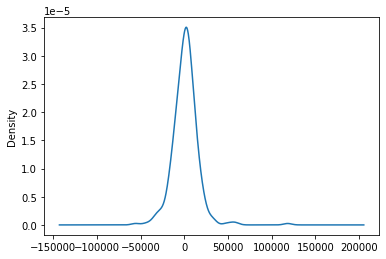

In [38]:
model_ARIMA_fit.resid.plot(kind='kde')

In [39]:
test_data['Predicted_ARIMA'] = pred

/var/folders/pt/fssyv3nx7f1dx2s0jz0zzdpw0000gn/T/ipykernel_7329/284031954.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_ARIMA'] = pred


<AxesSubplot:xlabel='date'>

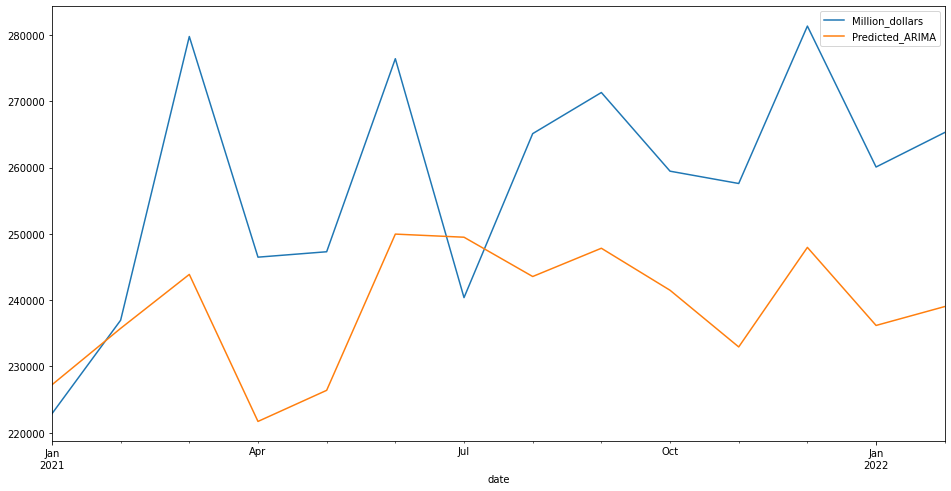

In [41]:
test_data[['Million_dollars', 'Predicted_ARIMA']].plot(figsize=(16,8))

In [42]:
# create a SARIMAX model 
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [43]:
df3['Million dollars yearly differencing'] = df3['Million_dollars'] - df3['Million_dollars'].shift(12) # yearly = 12 months  


In [46]:
adf_test(df3['Million dollars yearly differencing'].dropna())

ADF Statistics: -4.150215888970866
p- value: 0.0007991009868814938
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


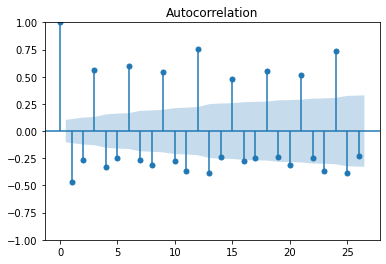

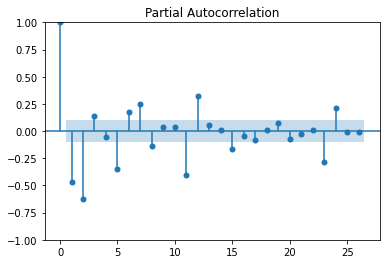

In [44]:
acf12 = plot_acf(df3['Million dollars differencing'].dropna())
pacf12 = plot_pacf(df3['Million dollars differencing'].dropna())

In [48]:
model_SARIMAX = SARIMAX(train_data['Million_dollars'], order=(18,1,18), seasonal_order=(0,0,0,12))
model_SARIMAX_fit = model_SARIMAX.fit()
model_SARIMAX_fit.summary()

/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('N

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           37     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21555D+01    |proj g|=  2.97000D+00

At iterate    5    f=  1.09118D+01    |proj g|=  1.39526D-01

At iterate   10    f=  1.08359D+01    |proj g|=  2.61151D-01

At iterate   15    f=  1.07773D+01    |proj g|=  1.14718D-01

At iterate   20    f=  1.07639D+01    |proj g|=  4.68486D-02

At iterate   25    f=  1.07442D+01    |proj g|=  2.02739D-01

At iterate   30    f=  1.07399D+01    |proj g|=  7.09052D-02

At iterate   35    f=  1.07324D+01    |proj g|=  5.51137D-01

At iterate   40    f=  1.07299D+01    |proj g|=  4.80621D-02

At iterate   45    f=  1.07286D+01    |proj g|=  6.94944D-02


/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.07262D+01    |proj g|=  1.91341D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   37     50     59      1     0     0   1.913D-01   1.073D+01
  F =   10.726236186929681     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        Million_dollars   No. Observations:                  347
Model:             SARIMAX(18, 1, 18)   Log Likelihood               -3722.004
Date:                Fri, 08 Apr 2022   AIC                           7518.008
Time:                        19:25:27   BIC                           7660.326
Sample:                    02-01-1992   HQIC                          7574.680
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1553      0.334      0.466      0.642      -0.498       0.809
ar.L2          0.2147      0.274      0.783      0.434      -0.323       0.752
ar.L3         -0.2240      0.309     -0.725      0.468      -0.830       0.382
ar.L4          0.1177      0.277      0.425      0.671      -0.425       0.660
ar.L5          0.3109      0.292      1.066      0.286      -0.261       0.882
ar.L6         -0.3825      0.348     -1.100      0.271      -1.064       0.299
ar.L7          0.0429      0.231      0.186      0.852      -0.409       0.495
ar.L8         -0.0393      0.209     -0.188      0.851      -0.449       0.371
ar.L9         -0.0367      0.234     -0.157      0.875      -0.496       0.422
ar.L10        -0.1000      0.247     -0.405      0.686      -0.584       0.384
ar.L11        -0.1399      0.251     -0.557      0.578      -0.632       0.352
ar.L12         0.7190      0.252      2.858      0.004       0.226       1.212
ar.L13        -0.3416      0.293     -1.166      0.244      -0.916       0.233
ar.L14        -0.3333      0.274     -1.215      0.224      -0.871       0.205
ar.L15         0.1207      0.228      0.530      0.596      -0.326       0.567
ar.L16        -0.1484      0.238     -0.623      0.533      -0.615       0.318
ar.L17        -0.3490      0.222     -1.571      0.116      -0.784       0.086
ar.L18         0.4754      0.217      2.195      0.028       0.051       0.900
ma.L1         -0.4756      0.339     -1.402      0.161      -1.141       0.189
ma.L2         -0.1999      0.260     -0.768      0.443      -0.710       0.311
ma.L3          0.3148      0.295      1.068      0.285      -0.263       0.892
ma.L4         -0.2681      0.271     -0.988      0.323      -0.800       0.264
ma.L5         -0.2405      0.298     -0.808      0.419      -0.824       0.343
ma.L6          0.4436      0.322      1.376      0.169      -0.188       1.076
ma.L7         -0.1176      0.234     -0.502      0.616      -0.577       0.342
ma.L8          0.0604      0.193      0.312      0.755      -0.319       0.440
ma.L9          0.0118      0.224      0.052      0.958      -0.428       0.452
ma.L10         0.0531      0.219      0.243      0.808      -0.375       0.482
ma.L11         0.1061      0.206      0.516      0.606      -0.297       0.510
ma.L12        -0.6319      0.200     -3.152      0.002      -1.025      -0.239
ma.L13         0.4121      0.281      1.464      0.143      -0.140       0.964
ma.L14         0.1999      0.219      0.911      0.362      -0.230       0.630
ma.L15        -0.2558      0.191     -1.338      0.181      -0.631       0.119
ma.L16         0.2213      0.221      1.000      0.317      -0.212       0.655
ma.L17         0.3429      0.205      1.673      0.094      -0.059       0.744
ma.L18        -0.5990      0.210     -2.857      0.004      -1.010      -0.188
sigma2      1.277e+08   1.33e-08   9.57e+15      0.000    1.28e+08    1.28e+08
=================================================================================

In [49]:
pred_SARIMAX = model_SARIMAX_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data['Million_dollars'] - pred_SARIMAX

<AxesSubplot:xlabel='date'>

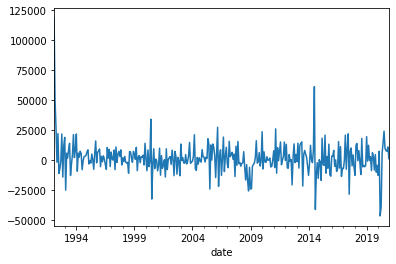

In [50]:
model_SARIMAX_fit.resid.plot()

<AxesSubplot:ylabel='Density'>

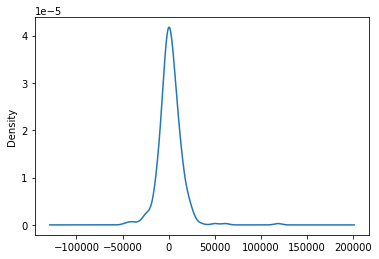

In [51]:
model_SARIMAX_fit.resid.plot(kind='kde')

In [52]:
test_data['Predicted_SARIMAX'] = pred_SARIMAX

/var/folders/pt/fssyv3nx7f1dx2s0jz0zzdpw0000gn/T/ipykernel_7329/1953269687.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_SARIMAX'] = pred_SARIMAX


<AxesSubplot:xlabel='date'>

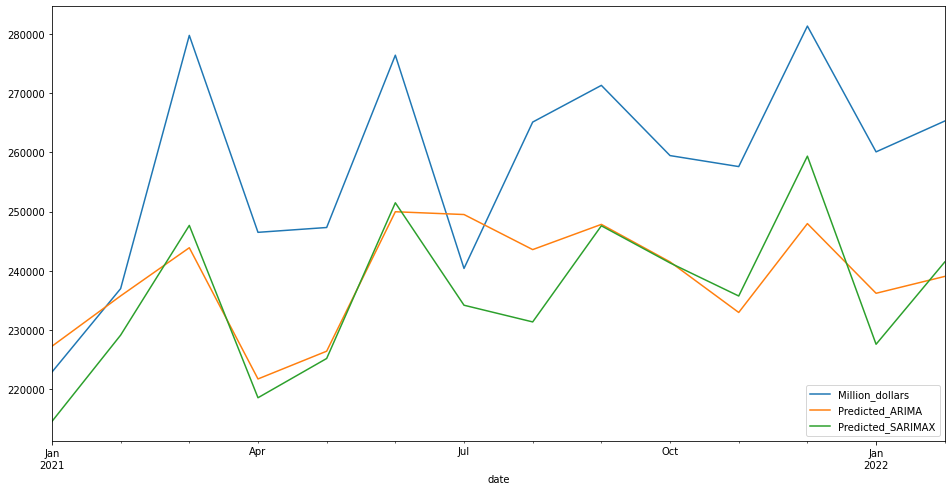

In [54]:
test_data[['Million_dollars', 'Predicted_ARIMA', 'Predicted_SARIMAX']].plot(figsize=(16,8))

## Orbit - Damped Local Trend (DLP) model 

In [55]:
!pip install orbit
!pip install orbit-ml

In [56]:
import orbit
from orbit.models.dlt import DLT
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components

/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [59]:
train_df = train_data[['Million_dollars']].reset_index()

In [60]:
test_df = test_data[['Million_dollars']].reset_index()

In [61]:
train_df.head()

date  Million_dollars
0 1992-02-01           118429
1 1992-03-01           129309
2 1992-04-01           123268
3 1992-05-01           122274
4 1992-06-01           131268

In [62]:
date_col = 'date'
response_col = 'Million_dollars'

In [63]:
# Define the DLT model
def createDLT(global_trend_option): 
  return DLT(
      response_col=response_col,
      date_col=date_col,
      seasonality=-1,
      estimator='stan-map',
      seed=8888,
      global_trend_option=global_trend_option, # linear, loglinear, flat, or logistic, 
      # for predicting uncertainty
      n_bootstrap_draws=1000,
  )

In [64]:
dlt_loglinear = createDLT('loglinear')
dlt_loglinear.fit(df=train_df)
predicted_df = dlt_loglinear.predict(df=test_df)

Initial log joint probability = -3967.89
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -3859.17      0.509328      0.605272           1           1       21   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39      -3858.72      0.431951       1.45921      0.5324      0.5324       49   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      44      -3858.71    0.00551974     0.0211076       0.215           1       55   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [65]:
predicted_df.head()

date   prediction_5     prediction  prediction_95
0 2021-01-01  196473.821460  224490.944840  251773.645402
1 2021-02-01  199196.423905  226730.434208  254868.368181
2 2021-03-01  201438.848917  228522.024284  257816.385005
3 2021-04-01  201006.035533  229955.294916  259950.713530
4 2021-05-01  199774.055850  231101.909983  260016.312204

In [66]:
prediction = predicted_df[['date', 'prediction']].set_index('date')
prediction.head()

prediction
date                     
2021-01-01  224490.944840
2021-02-01  226730.434208
2021-03-01  228522.024284
2021-04-01  229955.294916
2021-05-01  231101.909983

In [67]:
test_data['Predicted_DLT_LogLinear'] = prediction

/var/folders/pt/fssyv3nx7f1dx2s0jz0zzdpw0000gn/T/ipykernel_7329/540110592.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_DLT_LogLinear'] = prediction


In [68]:
test_data

Million_dollars  Predicted_ARIMA  Predicted_SARIMAX  \
date                                                              
2021-01-01           222873    227240.328956      214534.579557   
2021-02-01           236976    235748.679002      229118.032876   
2021-03-01           279768    243886.476113      247657.913448   
2021-04-01           246489    221713.377184      218537.634013   
2021-05-01           247305    226404.772936      225171.819730   
2021-06-01           276422    249967.732527      251484.352746   
2021-07-01           240387    249497.342597      234170.860770   
2021-08-01           265120    243571.626744      231350.139239   
2021-09-01           271323    247833.621623      247595.297975   
2021-10-01           259457    241496.889396      241320.095487   
2021-11-01           257601    232949.272255      235730.901592   
2021-12-01           281341    247963.814501      259361.104462   
2022-01-01           260087    236190.188336      227573.999334   
2022-02-01           265296    239040.519915      241477.470725   

            Predicted_DLT_LogLinear  
date                                 
2021-01-01            224490.944840  
2021-02-01            226730.434208  
2021-03-01            228522.024284  
2021-04-01            229955.294916  
2021-05-01            231101.909983  
2021-06-01            232019.200587  
2021-07-01            232753.031610  
2021-08-01            233340.094959  
2021-09-01            233809.744156  
2021-10-01            234185.462021  
2021-11-01            234486.034809  
2021-12-01            234726.491525  
2022-01-01            234918.855370  
2022-02-01            235072.744909

In [69]:
dlt_flat = createDLT('flat')
dlt_flat.fit(df=train_df)
predicted_df = dlt_flat.predict(df=test_df)

Initial log joint probability = -3969.36
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -3862.08      0.018031       0.29238           1           1       20   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      29      -3862.05    0.00145792    0.00109805     0.01542      0.9543       32   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [70]:
prediction = predicted_df[['date', 'prediction']].set_index('date')
prediction.head()

prediction
date                     
2021-01-01  224490.029633
2021-02-01  226732.494936
2021-03-01  228526.467177
2021-04-01  229961.644971
2021-05-01  231109.787205

In [71]:
test_data['Predicted_DLT_Flat'] = prediction

/var/folders/pt/fssyv3nx7f1dx2s0jz0zzdpw0000gn/T/ipykernel_7329/2472618137.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_DLT_Flat'] = prediction


In [72]:
test_data.head()

Million_dollars  Predicted_ARIMA  Predicted_SARIMAX  \
date                                                              
2021-01-01           222873    227240.328956      214534.579557   
2021-02-01           236976    235748.679002      229118.032876   
2021-03-01           279768    243886.476113      247657.913448   
2021-04-01           246489    221713.377184      218537.634013   
2021-05-01           247305    226404.772936      225171.819730   

            Predicted_DLT_LogLinear  Predicted_DLT_Flat  
date                                                     
2021-01-01            224490.944840       224490.029633  
2021-02-01            226730.434208       226732.494936  
2021-03-01            228522.024284       228526.467177  
2021-04-01            229955.294916       229961.644971  
2021-05-01            231101.909983       231109.787205

<AxesSubplot:xlabel='date'>

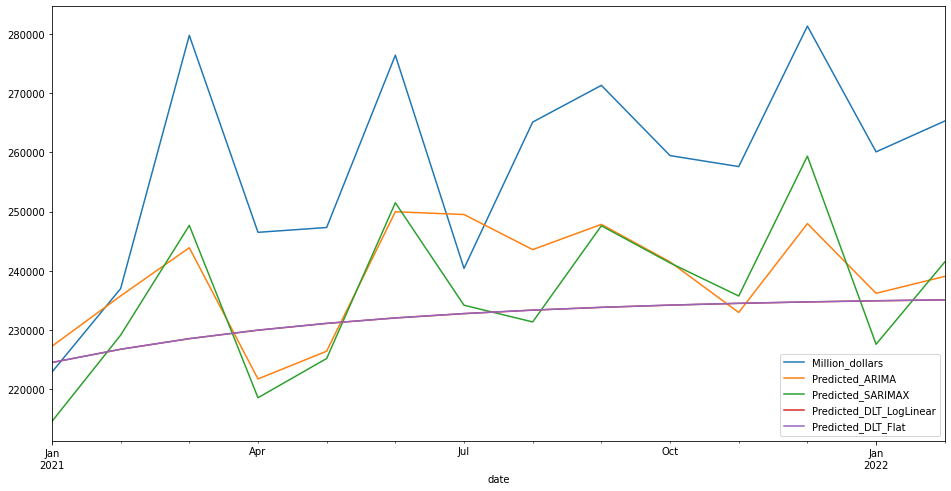

In [73]:
test_data[['Million_dollars', 'Predicted_ARIMA', 'Predicted_SARIMAX', 'Predicted_DLT_LogLinear', 'Predicted_DLT_Flat']].plot(figsize=(16,8))

## Prophet

In [74]:
!pip install prophet

In [75]:
from prophet import Prophet

ERROR:prophet.plot:Importing plotly failed. Interactive plots will not work.


In [76]:
train_df.columns

Index(['date', 'Million_dollars'], dtype='object')

In [80]:
proph_train = train_df.rename(columns={'date':'ds', 'Million_dollars': 'y'})
proph_test = test_df.rename(columns={'date':'ds', 'Million_dollars': 'y'})

In [81]:
proph_train.shape, proph_test.shape, train_df.shape, test_df.shape

((347, 2), (14, 2), (347, 2), (14, 2))

In [82]:
m = Prophet()
m.fit(proph_train)
future = m.make_future_dataframe(periods=len(proph_test), freq='MS')
forecast = m.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

Initial log joint probability = -3.64957
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       762.297    0.00319642       84.9789      0.1717           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       762.782   0.000341621       65.1711       0.173           1      264   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     247       762.786   1.10385e-08       54.0294     0.05596           1      333   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [83]:
forecast.head()

ds          trend     yhat_lower     yhat_upper    trend_lower  \
0 1992-02-01  127746.274278   99486.389536  147578.669108  127746.274278   
1 1992-03-01  128306.143608  122882.341957  169927.988032  128306.143608   
2 1992-04-01  128904.624615   97408.367276  146438.848527  128904.624615   
3 1992-05-01  129483.799783  102823.335117  152130.085957  129483.799783   
4 1992-06-01  130082.280790  123254.187356  170026.914195  130082.280790   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  127746.274278    -5216.428184          -5216.428184          -5216.428184   
1  128306.143608    18828.476274          18828.476274          18828.476274   
2  128904.624615    -7186.692662          -7186.692662          -7186.692662   
3  129483.799783    -1990.364034          -1990.364034          -1990.364034   
4  130082.280790    16722.762715          16722.762715          16722.762715   

         yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0  -5216.428184  -5216.428184  -5216.428184                   0.0   
1  18828.476274  18828.476274  18828.476274                   0.0   
2  -7186.692662  -7186.692662  -7186.692662                   0.0   
3  -1990.364034  -1990.364034  -1990.364034                   0.0   
4  16722.762715  16722.762715  16722.762715                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper           yhat  
0                         0.0                         0.0  122529.846094  
1                         0.0                         0.0  147134.619881  
2                         0.0                         0.0  121717.931953  
3                         0.0                         0.0  127493.435749  
4                         0.0                         0.0  146805.043506

In [84]:
forecast.tail()

ds          trend     yhat_lower     yhat_upper    trend_lower  \
356 2021-10-01  238981.981815  219657.657006  265955.347438  238895.783678   
357 2021-11-01  239200.752160  211798.103995  259081.963035  239096.423526   
358 2021-12-01  239412.465398  225142.024494  272166.421466  239289.754724   
359 2022-01-01  239631.235743  199158.197312  249758.169705  239486.307964   
360 2022-02-01  239850.006088  211264.254186  260865.213730  239679.378170   

       trend_upper  additive_terms  additive_terms_lower  \
356  239061.981104     3611.133389           3611.133389   
357  239306.415895    -4786.672341          -4786.672341   
358  239530.693590     8891.892358           8891.892358   
359  239770.447805   -16625.403689         -16625.403689   
360  240008.578159    -5136.632820          -5136.632820   

     additive_terms_upper        yearly  yearly_lower  yearly_upper  \
356           3611.133389   3611.133389   3611.133389   3611.133389   
357          -4786.672341  -4786.672341  -4786.672341  -4786.672341   
358           8891.892358   8891.892358   8891.892358   8891.892358   
359         -16625.403689 -16625.403689 -16625.403689 -16625.403689   
360          -5136.632820  -5136.632820  -5136.632820  -5136.632820   

     multiplicative_terms  multiplicative_terms_lower  \
356                   0.0                         0.0   
357                   0.0                         0.0   
358                   0.0                         0.0   
359                   0.0                         0.0   
360                   0.0                         0.0   

     multiplicative_terms_upper           yhat  
356                         0.0  242593.115203  
357                         0.0  234414.079819  
358                         0.0  248304.357756  
359                         0.0  223005.832054  
360                         0.0  234713.373268

In [85]:
test_data.tail()

Million_dollars  Predicted_ARIMA  Predicted_SARIMAX  \
date                                                              
2021-10-01           259457    241496.889396      241320.095487   
2021-11-01           257601    232949.272255      235730.901592   
2021-12-01           281341    247963.814501      259361.104462   
2022-01-01           260087    236190.188336      227573.999334   
2022-02-01           265296    239040.519915      241477.470725   

            Predicted_DLT_LogLinear  Predicted_DLT_Flat  
date                                                     
2021-10-01            234185.462021       234197.463155  
2021-11-01            234486.034809       234498.441752  
2021-12-01            234726.491525       234739.224631  
2022-01-01            234918.855370       234931.850934  
2022-02-01            235072.744909       235085.951976

In [89]:
len(test_data)

14

In [90]:
forecast[-14:].shape

(14, 16)

In [91]:
forecast.shape

(361, 16)

In [92]:
test_data.shape

(14, 5)

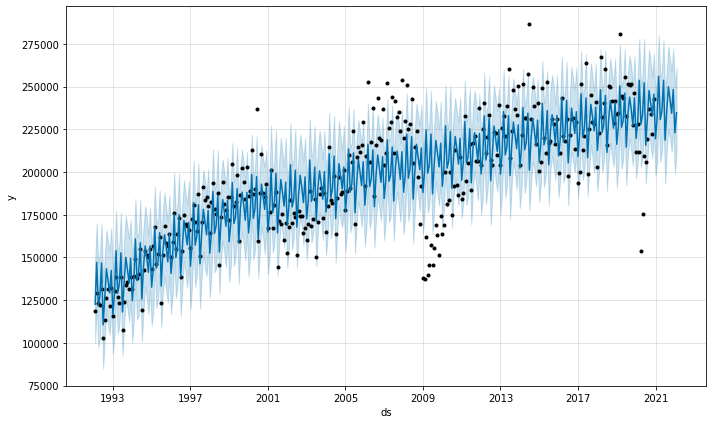

In [93]:
fig1 = m.plot(forecast)

/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


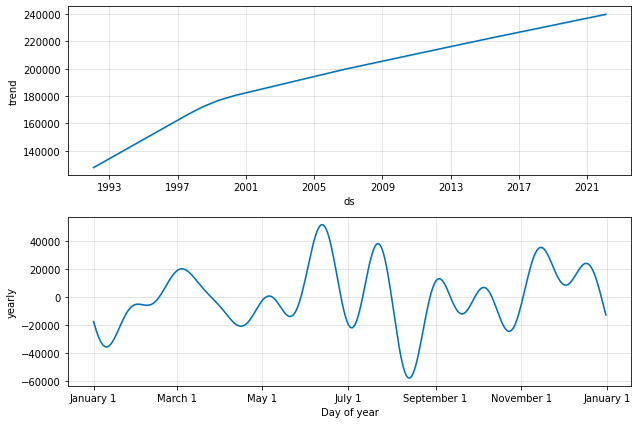

In [94]:
fig2 = m.plot_components(forecast)

In [95]:
test_data['Predicted_Prophet'] = forecast[-14:][['ds', 'yhat']].set_index('ds')

/var/folders/pt/fssyv3nx7f1dx2s0jz0zzdpw0000gn/T/ipykernel_7329/1285933153.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_Prophet'] = forecast[-14:][['ds', 'yhat']].set_index('ds')


In [96]:
test_data.head()

Million_dollars  Predicted_ARIMA  Predicted_SARIMAX  \
date                                                              
2021-01-01           222873    227240.328956      214534.579557   
2021-02-01           236976    235748.679002      229118.032876   
2021-03-01           279768    243886.476113      247657.913448   
2021-04-01           246489    221713.377184      218537.634013   
2021-05-01           247305    226404.772936      225171.819730   

            Predicted_DLT_LogLinear  Predicted_DLT_Flat  Predicted_Prophet  
date                                                                        
2021-01-01            224490.944840       224490.029633      219514.511901  
2021-02-01            226730.434208       226732.494936      232163.327716  
2021-03-01            228522.024284       228526.467177      256103.129665  
2021-04-01            229955.294916       229961.644971      230797.041499  
2021-05-01            231101.909983       231109.787205      235612.542877

<AxesSubplot:xlabel='date'>

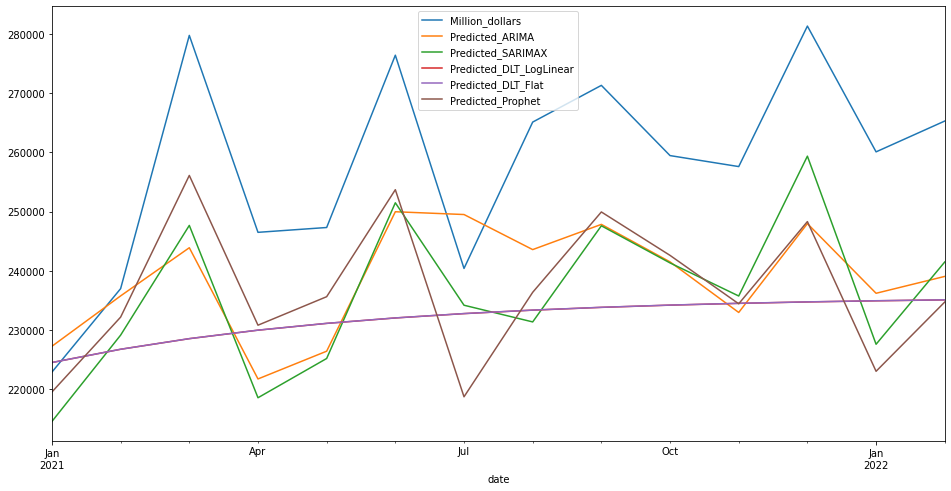

In [97]:
test_data[['Million_dollars', 'Predicted_ARIMA', 'Predicted_SARIMAX', 'Predicted_DLT_LogLinear', 'Predicted_DLT_Flat', 
           'Predicted_Prophet']].plot(figsize=(16,8))

### DeepAR

In [99]:
df3.shape

(361, 4)

In [100]:
df3.tail()

Million_dollars  Million dollars differencing  \
date                                                        
2021-10-01           259457                      -11866.0   
2021-11-01           257601                       -1856.0   
2021-12-01           281341                       23740.0   
2022-01-01           260087                      -21254.0   
2022-02-01           265296                        5209.0   

            Million dollars second differencing  \
date                                              
2021-10-01                             -18069.0   
2021-11-01                              10010.0   
2021-12-01                              25596.0   
2022-01-01                             -44994.0   
2022-02-01                              26463.0   

            Million dollars yearly differencing  
date                                             
2021-10-01                              25746.0  
2021-11-01                              35372.0  
2021-12-01                              38768.0  
2022-01-01                              37214.0  
2022-02-01                              28320.0

In [101]:
df3.head()

Million_dollars  Million dollars differencing  \
date                                                        
1992-02-01           118429                           NaN   
1992-03-01           129309                       10880.0   
1992-04-01           123268                       -6041.0   
1992-05-01           122274                        -994.0   
1992-06-01           131268                        8994.0   

            Million dollars second differencing  \
date                                              
1992-02-01                                  NaN   
1992-03-01                                  NaN   
1992-04-01                             -16921.0   
1992-05-01                               5047.0   
1992-06-01                               9988.0   

            Million dollars yearly differencing  
date                                             
1992-02-01                                  NaN  
1992-03-01                                  NaN  
1992-04-01                                  NaN  
1992-05-01                                  NaN  
1992-06-01                                  NaN

In [102]:
train_data.head()

Million_dollars
date                       
1992-02-01           118429
1992-03-01           129309
1992-04-01           123268
1992-05-01           122274
1992-06-01           131268

In [105]:
start = pd.Timestamp("2021-01-01", freq="MS")
train_ds = ListDataset([{'target': train_data.Million_dollars, 'start': start}], freq='MS')

/var/folders/pt/fssyv3nx7f1dx2s0jz0zzdpw0000gn/T/ipykernel_7329/203130734.py:1: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  start = pd.Timestamp("2021-01-01", freq="MS")


Test dataset: use the whole dataset, add 'target' and 'start' field

In [106]:
test_ds = ListDataset([{'target': df3.Million_dollars, 'start': start}], freq='MS')

In [107]:
np.random.seed(42)
mx.random.seed(42)

estimator = DeepAREstimator(
    prediction_length=14,
    context_length=15,
    freq='M',
    trainer=Trainer( # ctx="gpu",
                    epochs=25, learning_rate=1e-3, num_batches_per_epoch=100)
)
predictor = estimator.train(train_ds)

/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/gluonts/dataset/common.py:338: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return timestamp.freq.rollforward(timestamp)
/Users/wismineffendi/opt/anaconda3/envs/time-series/lib/python3.9/site-packages/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/Users/wismineffen

In [108]:
predictions = predictor.predict(test_ds)
predictions = list(predictions)[0]
predictions = predictions.quantile(0.5)

In [109]:
test_df.head()

date  Million_dollars
0 2021-01-01           222873
1 2021-02-01           236976
2 2021-03-01           279768
3 2021-04-01           246489
4 2021-05-01           247305

In [111]:
pred_df = pd.DataFrame(predictions)
pred_df.columns = ['Pred_Million_dollars']
pred_df

Pred_Million_dollars
0          299890.718750
1          252821.765625
2          262454.625000
3          282268.968750
4          248201.031250
5          267245.312500
6          272894.875000
7          255884.000000
8          247245.328125
9          261668.250000
10         237621.515625
11         250999.578125
12         275218.906250
13         239223.531250

In [115]:
test_data['Predicted_DeepAR'] = pd.concat([test_df.date, pred_df], axis=1).set_index('date')

/var/folders/pt/fssyv3nx7f1dx2s0jz0zzdpw0000gn/T/ipykernel_7329/2488335024.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_DeepAR'] = pd.concat([test_df.date, pred_df], axis=1).set_index('date')


<AxesSubplot:xlabel='date'>

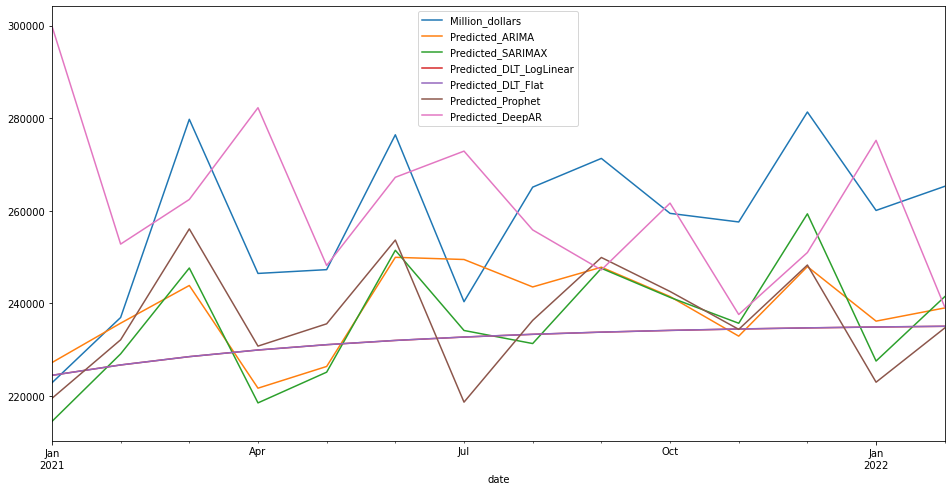

In [116]:
test_data[['Million_dollars', 'Predicted_ARIMA', 'Predicted_SARIMAX', 'Predicted_DLT_LogLinear', 'Predicted_DLT_Flat', 
           'Predicted_Prophet', 'Predicted_DeepAR']].plot(figsize=(16,8))

## Metrics

In [117]:
timeseries_evaluation_metrics_func(test_data.Million_dollars, test_data.Predicted_ARIMA)

Evaluation metric results:-
Mean Square Error is : 533024436.9145814
Mean Absolute Error is : 20992.550072961843
Root Mean Square Error is : 23087.32199529823
Mean Absolute Percentage Error is : 7.956498830836654
R2 score is : -0.923814558985113



In [118]:
timeseries_evaluation_metrics_func(test_data.Million_dollars, test_data.Predicted_SARIMAX)

Evaluation metric results:-
Mean Square Error is : 550871923.8623865
Mean Absolute Error is : 21811.485574859635
Root Mean Square Error is : 23470.660916607918
Mean Absolute Percentage Error is : 8.334725446337801
R2 score is : -0.9882304710026448



In [119]:
timeseries_evaluation_metrics_func(test_data.Million_dollars, test_data.Predicted_DLT_LogLinear)

Evaluation metric results:-
Mean Square Error is : 900677215.6364594
Mean Absolute Error is : 26254.901536007546
Root Mean Square Error is : 30011.284804827323
Mean Absolute Percentage Error is : 9.859252311420063
R2 score is : -2.250762667500871



In [120]:
timeseries_evaluation_metrics_func(test_data.Million_dollars, test_data.Predicted_DLT_Flat)

Evaluation metric results:-
Mean Square Error is : 900155834.2610356
Mean Absolute Error is : 26245.863508968123
Root Mean Square Error is : 30002.597125266264
Mean Absolute Percentage Error is : 9.855795647208497
R2 score is : -2.2488808755766017



In [121]:
timeseries_evaluation_metrics_func(test_data.Million_dollars, test_data.Predicted_Prophet)

Evaluation metric results:-
Mean Square Error is : 533799296.0873666
Mean Absolute Error is : 21038.941440960083
Root Mean Square Error is : 23104.09695459588
Mean Absolute Percentage Error is : 8.006972119806942
R2 score is : -0.9266112137996578



In [122]:
timeseries_evaluation_metrics_func(test_data.Million_dollars, test_data.Predicted_DeepAR)

Evaluation metric results:-
Mean Square Error is : 843072164.7197266
Mean Absolute Error is : 22541.973214285714
Root Mean Square Error is : 29035.704997807898
Mean Absolute Percentage Error is : 9.039244414637588
R2 score is : -2.0428520578744522



### Conclusion: 

Given the R2 scores are all negatives, the prediction are not so reliable. Looking at the MSE and MAE only we could say the ARIMA model gives the best prediction. 